GENERATING NAMES WITH A CHARACTER-LEVEL RNN  
https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [ ]:
a sequence is a name, a step is a character

Training with names and categories  
Given a category and a letter, after training, generate following characters to construct a name

for example, for input = 'Lee', target = 'eeEOS'  
L for e, e for e, e for EOS to fit

train method here is differenet from those in usual examples  
the method here is only resposible for one iteration

In [2]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1  # Plus EOS marker

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [3]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
def categoryTensor(cateogry):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        tensor[li][0][all_letters.find(line[li])] = 1
    return tensor

def targetTensor(line):
    letter_indices = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indices.append(n_letters - 1)
    return torch.LongTensor(letter_indices)

In [30]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [49]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):  # input is a letter
        input_combined = torch.cat([category, input, hidden], 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined) 
        output_combined = torch.cat([hidden, output], 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
        
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [52]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    # input_line_tensor : (len(line), 1, n_letters)
    
    target_line_tensor.unsqueeze_(-1)
    # if input.size(0) != target.size(0): raise ValueError, [1, 59] [1] so the same if unsqueezed
    # the error occurs in target.size(0) if not unsqueezed
    # EXAMPLE: torch.tensor(3).size(0) -> IndexError: dimension specified as 0 but tensor has no dimensions, size(0)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item() / input_line_tensor.size(0)

In [28]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [53]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 18s (5000 5%) 2.6451
0m 36s (10000 10%) 2.0805
0m 55s (15000 15%) 2.8677
1m 13s (20000 20%) 2.4283
1m 31s (25000 25%) 2.4670
1m 48s (30000 30%) 2.2772
2m 6s (35000 35%) 2.9754
2m 24s (40000 40%) 2.6658
2m 42s (45000 45%) 2.7741
3m 0s (50000 50%) 3.4482
3m 20s (55000 55%) 2.5521
3m 37s (60000 60%) 2.8183
3m 55s (65000 65%) 2.3104
4m 14s (70000 70%) 3.4578
4m 32s (75000 75%) 2.6381
4m 51s (80000 80%) 2.9840
5m 10s (85000 85%) 2.4368
5m 27s (90000 90%) 3.2855
5m 46s (95000 95%) 2.6218
6m 4s (100000 100%) 2.2552


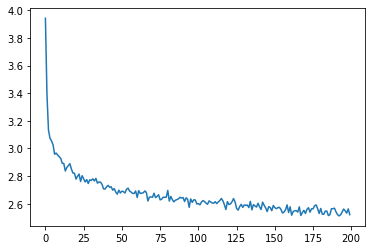

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [55]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

# generate three names in Russian each of staring from  R, U, S respectivly
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roun
Uari
San
Gara
Eara
Roun
Sallan
Pang
Allon
Chan
Hang
Ian


In [48]:
torch.tensor(3).size(0)

IndexError: dimension specified as 0 but tensor has no dimensions

In [11]:
_hidden = torch.zeros(1, 10)
_category = torch.zeros(1, 26)
_input = torch.zeros(1, 59)
torch.cat([_hidden, _category, _input], 1).shape

torch.Size([1, 95])

In [13]:
print(inputTensor('asdfa').shape)
print(inputTensor('asdfa')[1].shape)

torch.Size([5, 1, 59])
torch.Size([1, 59])


In [25]:
print(targetTensor('asdfa')[1], targetTensor('asdfa')[1].shape)
print(targetTensor('asdfa').unsqueeze(-1)[1], targetTensor('asdfa').unsqueeze(-1)[1].shape)

tensor(3) torch.Size([])
tensor([3]) torch.Size([1])
